In [1]:
%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LinearRegression


data_folder = os.path.join('../..', 'data')
file_name = "DataForModel"

# Logistic Regression

Another method to create predictions is to use logistic regression. We will use Multi-class Logistic Regression to predict the three possible outcomes of Home Win, Draw, or Away Win.

### Load Data

In [2]:
data = util.load_data(data_folder, file_name)
data = data[data['Div'] == 'E0']
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,...,Diff_shots_on_target_attempted,Diff_shots_on_target_allowed,Diff_shots_attempted,Diff_shots_allowed,Diff_corners_awarded,Diff_corners_conceded,Diff_fouls_commited,Diff_fouls_suffered,Diff_yellow_cards,Diff_red_cards
0,E0,2005-09-17,Aston Villa,Tottenham,1.0,1.0,0506,-25.173204,0.412832,0.245673,...,-9,10,-14,16,20,18,-13,9,-6,0
1,E0,2005-09-17,Portsmouth,Birmingham,1.0,1.0,0506,6.045620,0.468846,0.222236,...,4,-2,4,-4,0,13,6,17,1,0
2,E0,2005-09-17,Sunderland,West Brom,1.0,1.0,0506,-32.751187,0.399092,0.251422,...,9,-1,-4,8,5,0,-1,-21,-3,1
3,E0,2005-09-18,Blackburn,Newcastle,0.0,3.0,0506,34.014412,0.517707,0.201792,...,1,-13,7,-15,5,-14,0,-2,1,0
4,E0,2005-09-18,Man City,Bolton,0.0,1.0,0506,33.333649,0.516538,0.202282,...,3,3,-8,18,-4,2,-6,-17,3,0


### Define Features and Target

In [3]:
x_cols = ['ELO diff', 'Home_prob_ELO', 'Draw_prob_ELO', 'Away_prob_ELO',
       'Diff_goals_scored', 'Diff_goals_conceded', 'Matchrating',
       'Diff_points', 'Diff_change_in_ELO', 'Diff_opposition_mean_ELO',
       'Diff_shots_on_target_attempted', 'Diff_shots_on_target_allowed',
       'Diff_shots_attempted', 'Diff_shots_allowed', 'Diff_corners_awarded',
       'Diff_corners_conceded', 'Diff_fouls_commited', 'Diff_fouls_suffered',
       'Diff_yellow_cards', 'Diff_red_cards']
data["Outcome"] = data.apply(
    lambda row: (
        1 if row["FTHG"] > row["FTAG"] else (0 if row["FTHG"] == row["FTAG"] else -1)
    ),
    axis=1,
)
y_cols = ['Outcome']
X = data[x_cols]
y = data[y_cols]

### Create Train and Test set

Also, we will scale the features using StandardScaler.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Training the model

Now, let's train the model and look at the different metrics it gives us

Training accuracy: 0.543365307753797
Test accuracy: 0.5851318944844125
AUC for class -1: 0.75
AUC for class 0: 0.59
AUC for class 1: 0.75
Classification Report:
               precision    recall  f1-score   support

          -1       0.53      0.58      0.55       368
           0       0.00      0.00      0.00       268
           1       0.61      0.84      0.71       615

    accuracy                           0.59      1251
   macro avg       0.38      0.47      0.42      1251
weighted avg       0.46      0.59      0.51      1251



/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

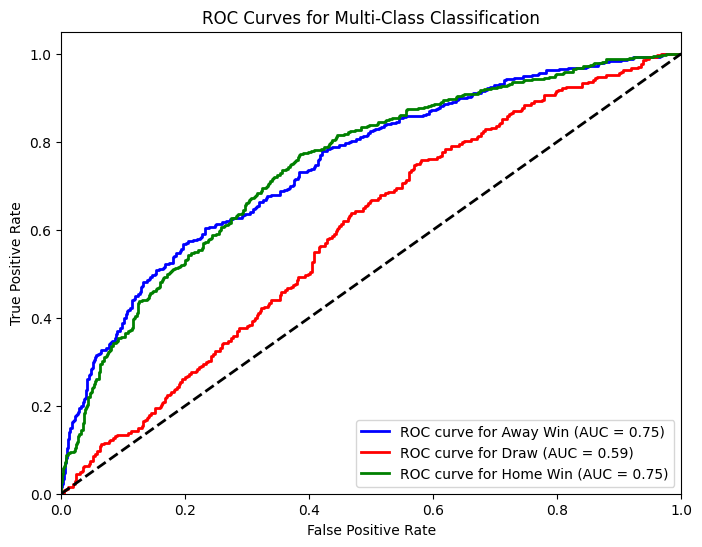

In [5]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Evaluate the model
print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# Compute AUC per class
y_pred_prob = model.predict_proba(X_test)
for i, class_label in enumerate(model.classes_):
    auc_score = roc_auc_score(y_test == class_label, y_pred_prob[:, i])
    print(f"AUC for class {class_label}: {auc_score:.2f}")

# Make predictions
y_pred = model.predict(X_test)


# Generate classification report
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

util.plot_multi_class_roc(
    y_test, y_pred_prob, classes=[-1, 0, 1], class_names=["Away Win", "Draw", "Home Win"]
)

The model gives a fair AUC score of 0.75 for Home and Away wins, but has a harder time predicting draws. We see from the classification report that the model in fact totally misses the draws. But the high score for the Home and Away wins is a good sign, which we can build upon. If we allow the model to only predict matches where there is a higher chance of either a Home or Away win, we might get a better model.

As an example, lets add the requirement that the ELO difference, signifying the long term strength difference, is greater than 100 in either direction. This will remove matches where the teams are very close in strength, and the model has a harder time predicting the outcome.

In [6]:
data_trimmed = data[(data['ELO diff'] > 100) | (data['ELO diff'] < -100)]
data_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3260 entries, 6 to 32527
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Div                             3260 non-null   object        
 1   Date                            3260 non-null   datetime64[ns]
 2   HomeTeam                        3260 non-null   object        
 3   AwayTeam                        3260 non-null   object        
 4   FTHG                            3260 non-null   float64       
 5   FTAG                            3260 non-null   float64       
 6   Season                          3260 non-null   object        
 7   ELO diff                        3260 non-null   float64       
 8   Home_prob_ELO                   3260 non-null   float64       
 9   Draw_prob_ELO                   3260 non-null   float64       
 10  Away_prob_ELO                   3260 non-null   float64       
 11  Diff_goa

We see the rows are almost cut in half, but if the model is better at predicting for this subset, it might be worth it

In [7]:
X = data_trimmed[x_cols]
y = data_trimmed[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training accuracy: 0.6196319018404908
Test accuracy: 0.6349693251533742
AUC for class -1: 0.79
AUC for class 0: 0.54
AUC for class 1: 0.78
Classification Report:
               precision    recall  f1-score   support

          -1       0.56      0.77      0.65       215
           0       0.25      0.02      0.03       114
           1       0.71      0.76      0.74       323

    accuracy                           0.63       652
   macro avg       0.51      0.52      0.47       652
weighted avg       0.58      0.63      0.58       652



/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


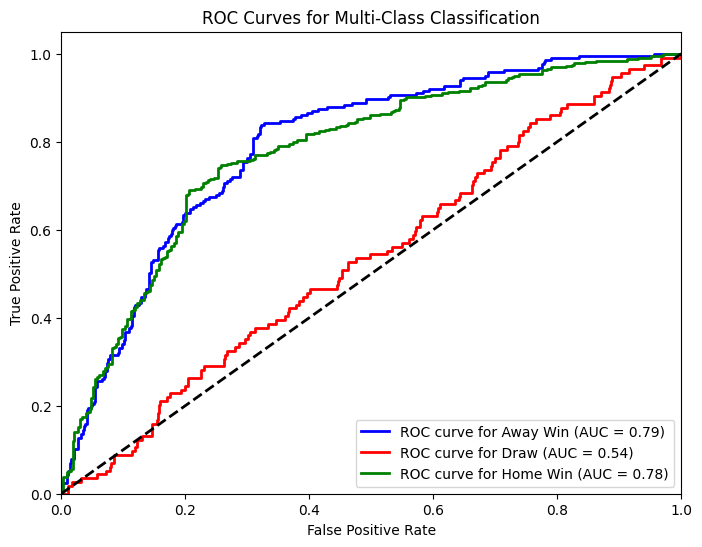

In [8]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Evaluate the model
print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# Compute AUC per class
y_pred_prob = model.predict_proba(X_test)
for i, class_label in enumerate(model.classes_):
    auc_score = roc_auc_score(y_test == class_label, y_pred_prob[:, i])
    print(f"AUC for class {class_label}: {auc_score:.2f}")

# Make predictions
y_pred = model.predict(X_test)


# Generate classification report
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

util.plot_multi_class_roc(
    y_test, y_pred_prob, classes=[-1, 0, 1], class_names=["Away Win", "Draw", "Home Win"]
)

From this, we see that both the AUC for Home and Away wins have increased, and the total accuracy for the test set has increased quite a lot. The recall from the whole dataset would be pretty bad, but for this specific subset, the performance is quite good.

### Setting a threshold

Finding a good threshold for what matches to cut involves finding a compromise between improving performance and reducing the eligible matches. Let's look at how moving the ELO threshold influences these metrics.

In [14]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

def evaluate_model(data, model, scaler: StandardScaler, threshold=0, column='ELO diff'):
	use_data = data.copy()
	use_data = use_data[(data[column] > threshold) | (data[column] < -threshold)]
	X, y = use_data[x_cols], use_data[y_cols]
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	X_train = scaler.fit_transform(X_train)
	X_test = scaler.transform(X_test)
	model.fit(X_train, y_train)

	training_accuracy = model.score(X_train, y_train)
	test_accuracy = model.score(X_test, y_test)
	

	# Compute AUC per class
	AUCs = []
	y_pred_prob = model.predict_proba(X_test)
	for i, class_label in enumerate(model.classes_):
		auc_score = roc_auc_score(y_test == class_label, y_pred_prob[:, i])
		AUCs.append(auc_score)
		
	#return training_accuracy, test_accuracy, AUCs
	return training_accuracy, test_accuracy, AUCs[0], AUCs[1], AUCs[2], len(use_data)/len(data)


/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

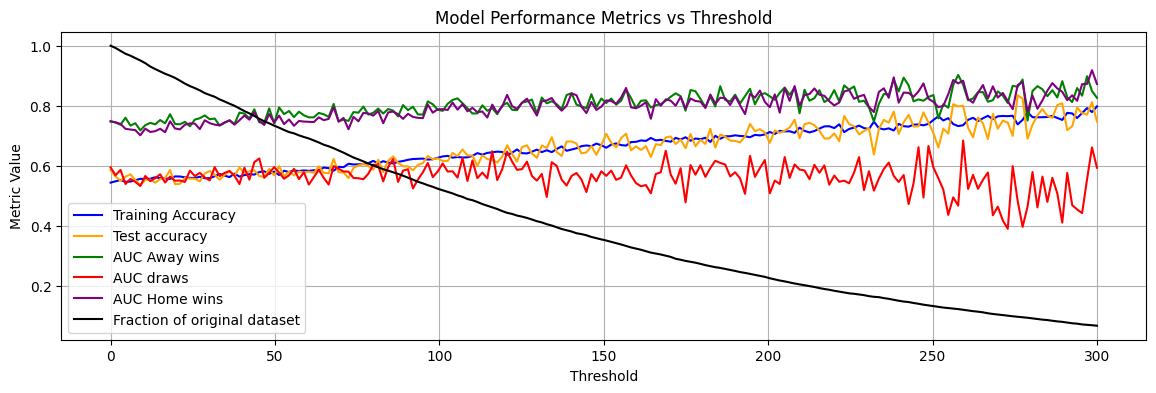

In [15]:
threshold_range = np.linspace(0, 300, 200)

results = {
    "threshold": [],
    "training_accuracy": [],
    "test_accuracy": [],
    "AUC_0": [],
    "AUC_1": [],
    "AUC_2": [],
    "fraction": []
}

for threshold in threshold_range:
    training_accuracy, test_accuracy, AUC_0, AUC_1, AUC_2, fraction = evaluate_model(data, model, scaler, threshold)
    results["threshold"].append(threshold)
    results["training_accuracy"].append(training_accuracy)
    results["test_accuracy"].append(test_accuracy)
    results["AUC_0"].append(AUC_0)
    results["AUC_1"].append(AUC_1)
    results["AUC_2"].append(AUC_2)
    results["fraction"].append(fraction)
    

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot each metric against the threshold range
util.plot_multiple_lines(results_df, x_col='threshold', line_cols=['training_accuracy', 'test_accuracy', 'AUC_0', 'AUC_1', 'AUC_2', 'fraction'], line_labels=['Training Accuracy', 'Test accuracy', 'AUC Away wins', 'AUC draws', 'AUC Home wins', 'Fraction of original dataset'], figsize=figsize)

We can see from the graph that as the dataset is more selective, the performance increases. There is therefore a tradeoff between performance and size of dataset due to requirements filtering out close matches.

### Using expected goal difference to set a threshold - KAOS HERFRA SKAL SLETTES

In [46]:
X = data[x_cols]
y = data['FTHG'] - data['FTAG']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)


In [47]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [48]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Training R-squared: {train_score:.2f}")
print(f"Test R-squared: {test_score:.2f}")

Training R-squared: 0.21
Test R-squared: 0.26


In [51]:
y_pred = model.predict(X_test)

# Add the predicted goal difference back to the original dataset
data['Expected Goal Difference'] = model.predict(X)
data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,...,Diff_shots_attempted,Diff_shots_allowed,Diff_corners_awarded,Diff_corners_conceded,Diff_fouls_commited,Diff_fouls_suffered,Diff_yellow_cards,Diff_red_cards,Outcome,Expected Goal Difference
0,E0,2005-09-17,Aston Villa,Tottenham,1.0,1.0,0506,-25.173204,0.412832,0.245673,...,-14,16,20,18,-13,9,-6,0,0,0.052308
1,E0,2005-09-17,Portsmouth,Birmingham,1.0,1.0,0506,6.045620,0.468846,0.222236,...,4,-4,0,13,6,17,1,0,0,0.411563
2,E0,2005-09-17,Sunderland,West Brom,1.0,1.0,0506,-32.751187,0.399092,0.251422,...,-4,8,5,0,-1,-21,-3,1,0,0.341048
3,E0,2005-09-18,Blackburn,Newcastle,0.0,3.0,0506,34.014412,0.517707,0.201792,...,7,-15,5,-14,0,-2,1,0,-1,0.718960
4,E0,2005-09-18,Man City,Bolton,0.0,1.0,0506,33.333649,0.516538,0.202282,...,-8,18,-4,2,-6,-17,3,0,-1,0.271698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32523,E0,2024-05-19,Crystal Palace,Aston Villa,5.0,0.0,2324,-90.969466,0.324565,0.233493,...,28,-42,5,-5,9,-12,4,1,1,0.453240
32524,E0,2024-05-19,Liverpool,Wolves,2.0,0.0,2324,243.886381,0.803305,0.082298,...,56,-18,16,-9,-5,-14,-10,0,1,1.772519
32525,E0,2024-05-19,Luton,Fulham,2.0,4.0,2324,-127.316525,0.287220,0.206627,...,-14,35,7,4,18,10,-1,-1,-1,-0.624331
32526,E0,2024-05-19,Man City,West Ham,3.0,1.0,2324,315.526105,0.862550,0.057509,...,2,-59,0,-13,-12,-1,-4,0,1,2.210613


In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
x_cols = ['ELO diff', 'Home_prob_ELO', 'Draw_prob_ELO', 'Away_prob_ELO',
       'Diff_goals_scored', 'Diff_goals_conceded', 'Matchrating',
       'Diff_points', 'Diff_change_in_ELO', 'Diff_opposition_mean_ELO',
       'Diff_shots_on_target_attempted', 'Diff_shots_on_target_allowed',
       'Diff_shots_attempted', 'Diff_shots_allowed', 'Diff_corners_awarded',
       'Diff_corners_conceded', 'Diff_fouls_commited', 'Diff_fouls_suffered',
       'Diff_yellow_cards', 'Diff_red_cards', 'Expected Goal Difference']

def cost(data, model, scaler: StandardScaler, threshold=0):
	use_data = data.copy()
	use_data = use_data[(data['Expected Goal Difference'] > threshold) | (data['Expected Goal Difference'] < -threshold)]
	X, y = use_data[x_cols], use_data[y_cols]
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	X_train = scaler.fit_transform(X_train)
	X_test = scaler.transform(X_test)
	model.fit(X_train, y_train)

	training_accuracy = model.score(X_train, y_train)
	test_accuracy = model.score(X_test, y_test)
	

	# Compute AUC per class
	AUCs = []
	y_pred_prob = model.predict_proba(X_test)
	for i, class_label in enumerate(model.classes_):
		auc_score = roc_auc_score(y_test == class_label, y_pred_prob[:, i])
		AUCs.append(auc_score)
		
	#return training_accuracy, test_accuracy, AUCs
	return training_accuracy, test_accuracy, AUCs[0], AUCs[1], AUCs[2], len(use_data)/len(data)

cost(data, model, scaler, threshold=0)

/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


(0.543365307753797,
 0.5843325339728217,
 np.float64(0.7486736176079571),
 np.float64(0.5944299357738267),
 np.float64(0.7470189701897019),
 1.0)

/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

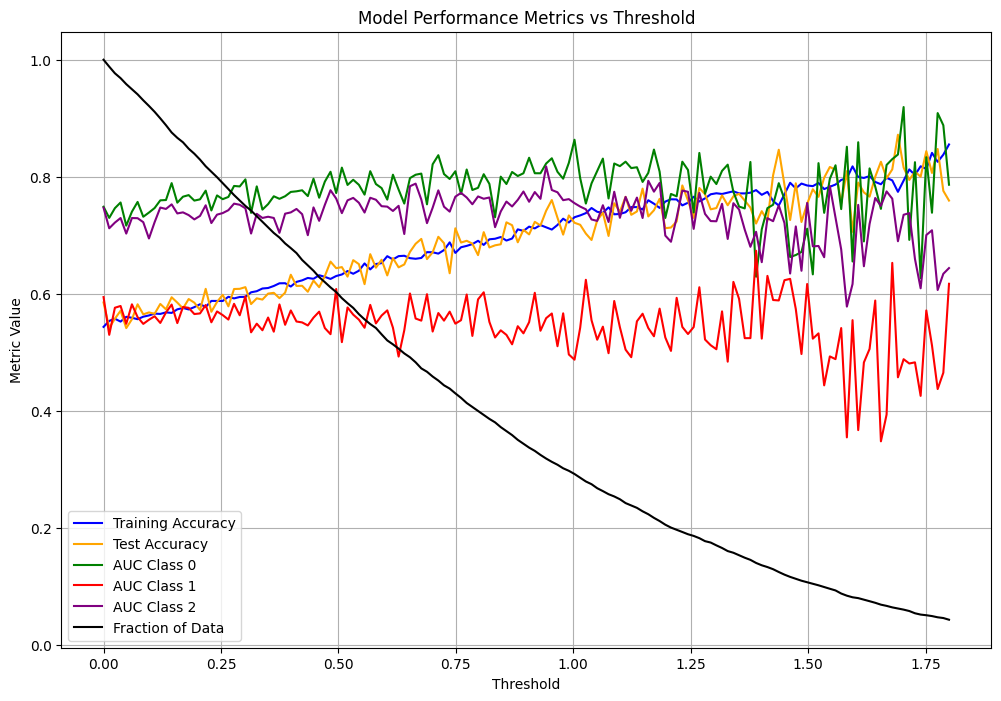

In [103]:
import matplotlib.pyplot as plt

# Assuming `data`, `model`, and `scaler` are already defined in your environment
# Generate a range of threshold values
threshold_range = np.linspace(0, 1.8, 150)

# Collect the results for each threshold value
results = {
    "threshold": [],
    "training_accuracy": [],
    "test_accuracy": [],
    "AUC_0": [],
    "AUC_1": [],
    "AUC_2": [],
    "fraction": []
}

for threshold in threshold_range:
    training_accuracy, test_accuracy, AUC_0, AUC_1, AUC_2, fraction = cost(data, model, scaler, threshold)
    results["threshold"].append(threshold)
    results["training_accuracy"].append(training_accuracy)
    results["test_accuracy"].append(test_accuracy)
    results["AUC_0"].append(AUC_0)
    results["AUC_1"].append(AUC_1)
    results["AUC_2"].append(AUC_2)
    results["fraction"].append(fraction)
    

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot each metric against the threshold range
plt.figure(figsize=(12, 8))
plt.plot(results_df["threshold"], results_df["training_accuracy"], label="Training Accuracy", color="blue")
plt.plot(results_df["threshold"], results_df["test_accuracy"], label="Test Accuracy", color="orange")
plt.plot(results_df["threshold"], results_df["AUC_0"], label="AUC Class 0", color="green")
plt.plot(results_df["threshold"], results_df["AUC_1"], label="AUC Class 1", color="red")
plt.plot(results_df["threshold"], results_df["AUC_2"], label="AUC Class 2", color="purple")
plt.plot(results_df["threshold"], results_df["fraction"], label="Fraction of Data", color="black")

# Add plot labels and legend
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Model Performance Metrics vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [89]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
x_cols = ['ELO diff', 'Home_prob_ELO', 'Draw_prob_ELO', 'Away_prob_ELO',
       'Diff_goals_scored', 'Diff_goals_conceded', 'Matchrating',
       'Diff_points', 'Diff_change_in_ELO', 'Diff_opposition_mean_ELO',
       'Diff_shots_on_target_attempted', 'Diff_shots_on_target_allowed',
       'Diff_shots_attempted', 'Diff_shots_allowed', 'Diff_corners_awarded',
       'Diff_corners_conceded', 'Diff_fouls_commited', 'Diff_fouls_suffered',
       'Diff_yellow_cards', 'Diff_red_cards']

def cost_2(data, model, scaler: StandardScaler, threshold=0):
	use_data = data.copy()
	use_data = use_data[(data['ELO diff'] > threshold) | (data['ELO diff'] < -threshold)]
	X, y = use_data[x_cols], use_data[y_cols]
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	X_train = scaler.fit_transform(X_train)
	X_test = scaler.transform(X_test)
	model.fit(X_train, y_train)

	training_accuracy = model.score(X_train, y_train)
	test_accuracy = model.score(X_test, y_test)
	

	# Compute AUC per class
	AUCs = []
	y_pred_prob = model.predict_proba(X_test)
	for i, class_label in enumerate(model.classes_):
		auc_score = roc_auc_score(y_test == class_label, y_pred_prob[:, i])
		AUCs.append(auc_score)
		
	#return training_accuracy, test_accuracy, AUCs
	return training_accuracy, test_accuracy, AUCs[0], AUCs[1], AUCs[2], len(use_data)/len(data)



/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

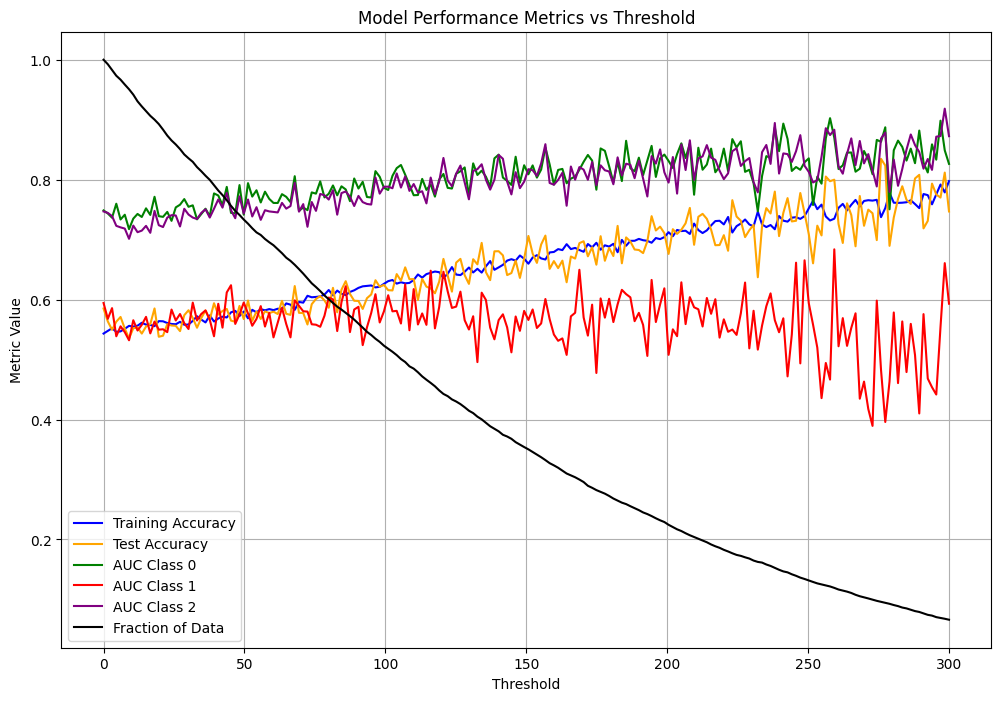

In [96]:
import matplotlib.pyplot as plt

# Assuming `data`, `model`, and `scaler` are already defined in your environment
# Generate a range of threshold values
threshold_range = np.linspace(0, 300, 200)

# Collect the results for each threshold value
results = {
    "threshold": [],
    "training_accuracy": [],
    "test_accuracy": [],
    "AUC_0": [],
    "AUC_1": [],
    "AUC_2": [],
    "fraction": []
}

for threshold in threshold_range:
    training_accuracy, test_accuracy, AUC_0, AUC_1, AUC_2, fraction = cost_2(data, model, scaler, threshold)
    results["threshold"].append(threshold)
    results["training_accuracy"].append(training_accuracy)
    results["test_accuracy"].append(test_accuracy)
    results["AUC_0"].append(AUC_0)
    results["AUC_1"].append(AUC_1)
    results["AUC_2"].append(AUC_2)
    results["fraction"].append(fraction)
    

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot each metric against the threshold range
plt.figure(figsize=(12, 8))
plt.plot(results_df["threshold"], results_df["training_accuracy"], label="Training Accuracy", color="blue")
plt.plot(results_df["threshold"], results_df["test_accuracy"], label="Test Accuracy", color="orange")
plt.plot(results_df["threshold"], results_df["AUC_0"], label="AUC Class 0", color="green")
plt.plot(results_df["threshold"], results_df["AUC_1"], label="AUC Class 1", color="red")
plt.plot(results_df["threshold"], results_df["AUC_2"], label="AUC Class 2", color="purple")
plt.plot(results_df["threshold"], results_df["fraction"], label="Fraction of Data", color="black")

# Add plot labels and legend
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Model Performance Metrics vs Threshold")
plt.legend()
plt.grid(True)
plt.show()